# Multi-Class Logistic Regression

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (7,4)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [50]:
df = pd.read_csv('iris.csv')

In [51]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


## Exploratory Data Analysis and Visualization

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [53]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


In [54]:
df['species'].value_counts()

species
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

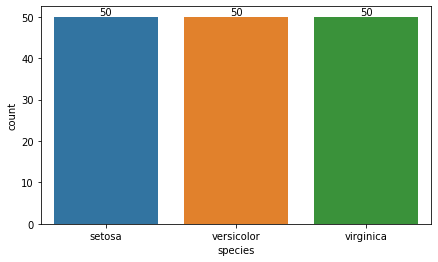

In [55]:
ax = sns.countplot(data = df, x ='species')
ax.bar_label(ax.containers[0]);

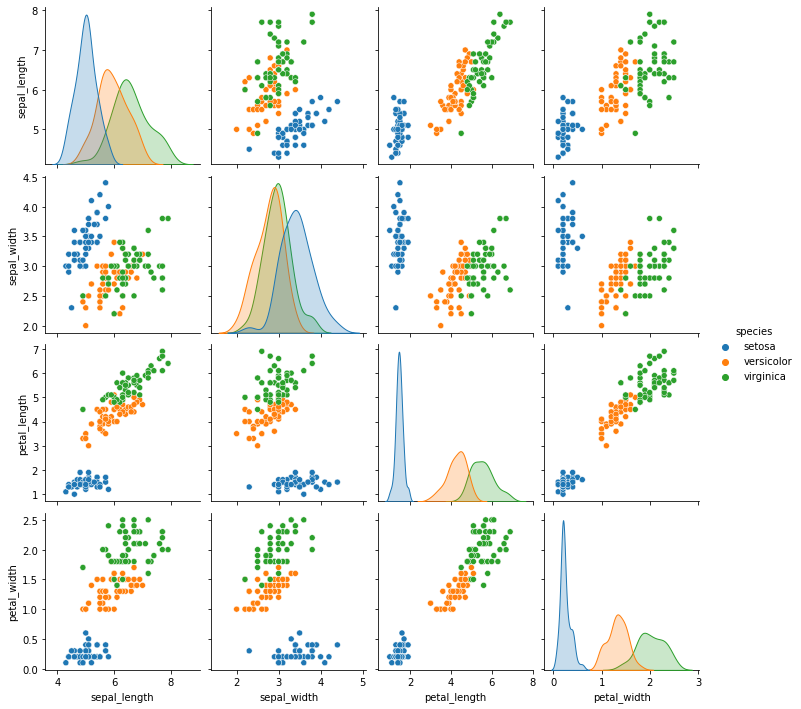

In [56]:
sns.pairplot(df,hue='species');

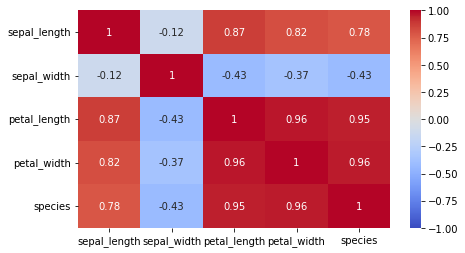

In [57]:
species_mapping = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
df['species'] = df['species'].map(species_mapping)
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap="coolwarm");

## Train | Test Split and Modeling

In [58]:
X = df.drop('species',axis=1)
y = df['species']

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

# You can use stratify=y whether your data is inbalanced or balanced. 
# But you should definitely use inbalanced data, since the data is balanced, we didn't feel the need to use it here.

In [61]:
operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression())]

pipe_model = Pipeline(steps=operations)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression())])

## Model Performance

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

### With Default Parameters

In [63]:
y_pred = pipe_model.predict(X_test)
y_pred

# target can be numeric data or object data.

array([0, 0, 0, 2, 1, 2, 1, 1, 2, 0, 2, 0, 0, 2, 2, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 2, 0, 0])

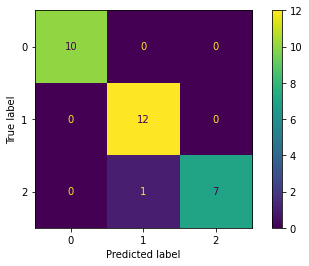

In [64]:
ConfusionMatrixDisplay.from_estimator(pipe_model, X_test, y_test);

In [65]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [66]:
eval_metric(pipe_model, X_train, y_train, X_test, y_test)

# In multiclass classification problems, if all classes have the same importance
# It will be more accurate to evaluate the results according to macro, weighted or accuracy scores.

# macro avg: treats all classes equally.
# If we want the scores of the class with more observations to come to the fore, weighted avg is used.

# micro_scores are equal to accuracy. It can be used if the data is balanced.

Test_Set
[[10  0  0]
 [ 0 12  0]
 [ 0  1  7]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.92      1.00      0.96        12
           2       1.00      0.88      0.93         8

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.96        30
weighted avg       0.97      0.97      0.97        30


Train_Set
[[40  0  0]
 [ 0 35  3]
 [ 0  1 41]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.92      0.95        38
           2       0.93      0.98      0.95        42

    accuracy                           0.97       120
   macro avg       0.97      0.97      0.97       120
weighted avg       0.97      0.97      0.97       120



### Cross Validate

In [67]:
from sklearn.model_selection import cross_validate

operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression())]

model = Pipeline(steps=operations)

scores = cross_validate(model, X_train, y_train, scoring = ['accuracy', 'precision_weighted','recall_weighted',
                                                                   'f1_weighted'], cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# We do not use precision, recall and f1 metrics alone for CV or gridsearchCV in multiclass data.
# As it is stated above, precision_weighted, precision_macro, precision_micro etc.
# Otherwise you will get an error. If we want to see the CV scores of a single class specifically,
# we should use the make_scorer function as shown below.

test_accuracy               0.950000
train_accuracy              0.963889
test_precision_weighted     0.960000
train_precision_weighted    0.964076
test_recall_weighted        0.950000
train_recall_weighted       0.963889
test_f1_weighted            0.949206
train_f1_weighted           0.963872
dtype: float64

### Cross Validate for versicolar

In [68]:
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score


# 'setosa': 0, 'versicolor': 1, 'virginica': 2
f1_versicolor = make_scorer(f1_score, average=None, labels =[1])
precision_versicolor = make_scorer(precision_score, average=None, labels =[1])
recall_versicolor = make_scorer(recall_score,  average=None, labels =[1])


scoring = {"f1_versicolor":f1_versicolor, 
           "precision_versicolor":precision_versicolor,
           "recall_versicolor":recall_versicolor}

# In multiclass data, you can get CV scores on whatever your target label is. 
# Again we have to use the make_scorer function.
# When the data is multi-class, average, and labels parameters must be specified in the make_scorer function.
# Label names should be given as a list.
# If we are defining a scorer for a single class, average: None should be set.

In [69]:
operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression())]
model = Pipeline(steps=operations)

scores = cross_validate(model, X_train, y_train, scoring = scoring, cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

#no overfitting

test_f1_versicolor            0.923810
train_f1_versicolor           0.942656
test_precision_versicolor     0.940000
train_precision_versicolor    0.949885
test_recall_versicolor        0.925000
train_recall_versicolor       0.935798
dtype: float64

## Class prediction

In [71]:
y_pred=pipe_model.predict(X_test)
y_pred_proba = pipe_model.predict_proba(X_test)

test_data = pd.concat([X_test, y_test], axis=1)

test_data["pred"] = y_pred
test_data["pred_proba_setosa"] = y_pred_proba[:,0]
test_data["pred_proba_versicolar"] = y_pred_proba[:,1]
test_data["pred_proba_virginica"] = y_pred_proba[:,2]
test_data.sample(10)

# 0.5 threshold is not sought in multiclass data. Whichever class has the highest probability it is assigned to that class.

,sepal_length,sepal_width,petal_length,petal_width,species,pred,pred_proba_setosa,pred_proba_versicolar,pred_proba_virginica
96,5.7,2.9,4.2,1.3,1,1,0.051401,0.875025,7.357360e-02
93,5.0,2.3,3.3,1.0,1,1,0.050988,0.935894,1.311761e-02
48,5.3,3.7,1.5,0.2,0,0,0.986904,0.013096,1.546878e-07
50,7.0,3.2,4.7,1.4,1,1,0.009149,0.851715,1.391362e-01
53,5.5,2.3,4.0,1.3,1,1,0.008192,0.886796,1.050119e-01
88,5.6,3.0,4.1,1.3,1,1,0.096310,0.846122,5.756797e-02
122,7.7,2.8,6.7,2.0,2,2,0.000002,0.026415,9.735836e-01
16,5.4,3.9,1.3,0.4,0,0,0.992630,0.007370,1.329227e-07
64,5.6,2.9,3.6,1.3,1,1,0.099521,0.865612,3.486680e-02
42,4.4,3.2,1.3,0.2,0,0,0.984541,0.015459,2.471313e-07


### With Best Parameters (GridsearchCV)

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [72]:
operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression(max_iter=5000))]

model = Pipeline(steps=operations)

In [75]:
model.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('logistic', LogisticRegression(max_iter=5000))],
 'verbose': False,
 'scaler': StandardScaler(),
 'logistic': LogisticRegression(max_iter=5000),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'logistic__C': 1.0,
 'logistic__class_weight': None,
 'logistic__dual': False,
 'logistic__fit_intercept': True,
 'logistic__intercept_scaling': 1,
 'logistic__l1_ratio': None,
 'logistic__max_iter': 5000,
 'logistic__multi_class': 'auto',
 'logistic__n_jobs': None,
 'logistic__penalty': 'l2',
 'logistic__random_state': None,
 'logistic__solver': 'lbfgs',
 'logistic__tol': 0.0001,
 'logistic__verbose': 0,
 'logistic__warm_start': False}

In [76]:
penalty = ["l1", "l2"]
C = [0.01, 0.1, 1, 5, 16, 19, 22, 25]

param_grid = {"logistic__penalty" : penalty,
             "logistic__C" : C}

In [77]:
grid_model = GridSearchCV(model, param_grid = param_grid, cv=5, return_train_score=True)

#scoring = f1_versicolor = make_scorer(f1_score, average = None, labels =["versicolor"]) 

# scoring is accuracy by default in the classification. If we want to improve the metrics of a particular class, 
# we should define the make_scorer function as the scoring parameter above.

# If we wanted the model to find the best parameters to improve the f1_score of the versicolor class make scorer would be
# scoring = make_scorer(f1_score, average = None, labels =["versicolor"]) 

In [78]:
grid_model.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('logistic',
                                        LogisticRegression(max_iter=5000))]),
             param_grid={'logistic__C': [0.01, 0.1, 1, 5, 16, 19, 22, 25],
                         'logistic__penalty': ['l1', 'l2']},
             return_train_score=True)

In [79]:
grid_model.best_params_

{'logistic__C': 19, 'logistic__penalty': 'l2'}

In [80]:
grid_model.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression(C=19, max_iter=5000))])

In [81]:
pd.DataFrame(grid_model.cv_results_).loc[grid_model.best_index_, ["mean_test_score", "mean_train_score"]]

mean_test_score       0.975
mean_train_score    0.98125
Name: 11, dtype: object

In [82]:
y_pred = grid_model.predict(X_test)
y_pred

array([0, 0, 0, 2, 1, 2, 1, 1, 2, 0, 2, 0, 0, 2, 2, 1, 1, 1, 0, 2, 1, 0,
       1, 1, 1, 1, 1, 2, 0, 0])

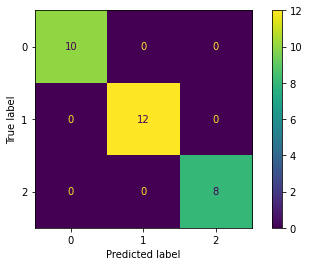

In [83]:
ConfusionMatrixDisplay.from_estimator(grid_model, X_test, y_test);

In [84]:
eval_metric(grid_model, X_train, y_train, X_test, y_test)

Test_Set
[[10  0  0]
 [ 0 12  0]
 [ 0  0  8]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00         8

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Train_Set
[[40  0  0]
 [ 0 37  1]
 [ 0  1 41]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        40
           1       0.97      0.97      0.97        38
           2       0.98      0.98      0.98        42

    accuracy                           0.98       120
   macro avg       0.98      0.98      0.98       120
weighted avg       0.98      0.98      0.98       120



## ROC (Receiver Operating Curve) and AUC (Area Under Curve)

In [86]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

In [89]:
# !conda install -c conda-forge scikit-plot

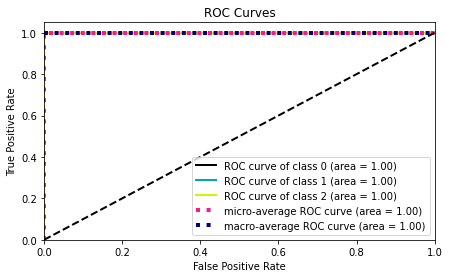

In [90]:
from scikitplot.metrics import plot_roc, precision_recall_curve
from scikitplot.metrics import plot_precision_recall


operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression(C=19, max_iter=5000))]

model = Pipeline(steps=operations)

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
    
plot_roc(y_test, y_pred_proba)
plt.show();

In [99]:
from sklearn.metrics import average_precision_score, roc_auc_score

y_test_dummies = pd.get_dummies(y_test).values

roc_auc_score(y_test_dummies[:, 1], y_pred_proba[:, 1])  # roc_auc score  for setosa

1.0

In [100]:
y_test[:5]

33     0
16     0
43     0
129    2
50     1
Name: species, dtype: int64

In [101]:
y_test_dummies[:5]

array([[ True, False, False],
       [ True, False, False],
       [ True, False, False],
       [False, False,  True],
       [False,  True, False]])

## Precision Recall Curve

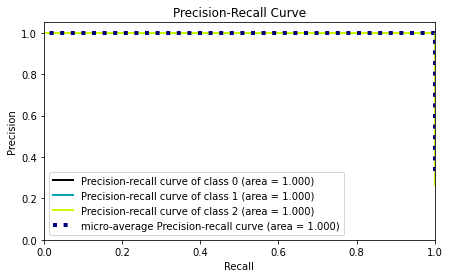

In [102]:
from scikitplot.metrics import plot_roc, precision_recall_curve
from scikitplot.metrics import plot_precision_recall


operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression(C=19, max_iter=5000))]

model = Pipeline(steps=operations)

model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)
    
plot_precision_recall(y_test, y_pred_proba)
plt.show();

In [103]:
from sklearn.metrics import average_precision_score, roc_auc_score

y_test_dummies = pd.get_dummies(y_test).values

average_precision_score(y_test_dummies[:, 1], y_pred_proba[:, 1])

1.0

## Final Model and Model Deployment

In [105]:
operations = [("scaler", StandardScaler()), ("logistic", LogisticRegression())]

final_model = Pipeline(steps=operations)

final_model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic', LogisticRegression())])

In [106]:
import pickle
pickle.dump(final_model, open("final_pipe_model", 'wb'))

In [107]:
new_model = pickle.load(open("final_pipe_model", "rb"))

In [108]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


In [109]:
my_dict = {"sepal_length": [4.5, 5.8, 7.5],
           "sepal_width": [2.2, 3, 4.2],
           "petal_length": [1.3, 4.3, 6.5],
           "petal_width": [0.2, 1.3, 2.3]
          }

In [110]:
sample = pd.DataFrame(my_dict)
sample

,sepal_length,sepal_width,petal_length,petal_width
0,4.5,2.2,1.3,0.2
1,5.8,3.0,4.3,1.3
2,7.5,4.2,6.5,2.3


In [111]:
predictions = final_model.predict(sample)
predictions_proba = final_model.predict_proba(sample)

In [112]:
sample["pred"] = predictions
sample["pred_proba_setosa"] = predictions_proba[:,0]
sample["pred_proba_versicolor"] = predictions_proba[:,1]
sample["pred_proba_virginica"] = predictions_proba[:,2]
sample

,sepal_length,sepal_width,petal_length,petal_width,pred,pred_proba_setosa,pred_proba_versicolor,pred_proba_virginica
0,4.5,2.2,1.3,0.2,0,0.712393,0.287603,0.000004
1,5.8,3.0,4.3,1.3,1,0.044001,0.890134,0.065864
2,7.5,4.2,6.5,2.3,2,0.000085,0.020543,0.979372
